## Projet IA : Détection de Fraude Bancaire

### Modèle Random Forest pour identifier les transactions suspectes

# **Dataset**: Credit Card Fraud Detection de Kaggle

### 1. Installation et importation des librairies

In [2]:
# !pip install scikit-learn imbalanced-learn matplotlib seaborn numpy pandas plotly -q

In [3]:
# Scikit-learn imports:
# train_test_split: Diviser données en train/test
# StratifiedKFold: Validation croisée qui préserve la distribution des classes
# GridSearchCV: Recherche d'hyperparamètres
# cross_val_score: Score de validation croisée
# StandardScaler/RobustScaler: Normalisation des caractéristiques
# RandomForestClassifier: Modèle principal
# Toutes les métriques pour l'évaluation

# Imbalanced-learn:
# SMOTE: Crée des échantillons synthétiques pour la classe minoritaire
# RandomUnderSampler: Réduit la classe majoritaire
# SMOTETomek: Combinaison de SMOTE et undersampling

# Autres:
# joblib: Sauvegarde/chargement de modèles
# time/datetime: Mesure du temps d'exécution
# json: Pour sauvegarder des configurations

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # plotly pour des graphiques interactifs
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Imbalanced-learn
from imblearn.over_sampling import SMOTE # pour gérer le déséquilibre des classes (SMOTE, RandomUnderSampler)
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# Autres
import joblib
import time
from datetime import datetime
import json

In [5]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("les Librairies importées avec succès!")

les Librairies importées avec succès!


### 2. Chargement des données

In [6]:
df = pd.read_csv('creditcard.csv')

# Affichage des premières lignes
print("Dimensions du dataset:", df.shape) #: Retourne (nombre_lignes, nombre_colonnes)
print("\nAperçu des données:")
df.head()

Dimensions du dataset: (284807, 31)

Aperçu des données:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Informations sur le dataset
print("Informations sur le dataset:")
print(df.info())
# Statistiques descriptives
print("Statistiques descriptives:")
df.describe()

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### 3. Analyse exploratoire des données (EDA)

#### 3.1 Distribution des classes (Target)

In [8]:
# Distribution des classes
class_counts = df['Class'].value_counts() #value_counts(): Compte les occurrences de chaque classe
class_percentage = df['Class'].value_counts(normalize=True) * 100 #normalize=True: Donne les proportions au lieu des counts

print(" Distribution des classes:")
print(f"Transactions normales (0): {class_counts[0]:,} ({class_percentage[0]:.2f}%)")
print(f"Transactions frauduleuses (1): {class_counts[1]:,} ({class_percentage[1]:.2f}%)")

 Distribution des classes:
Transactions normales (0): 284,315 (99.83%)
Transactions frauduleuses (1): 492 (0.17%)


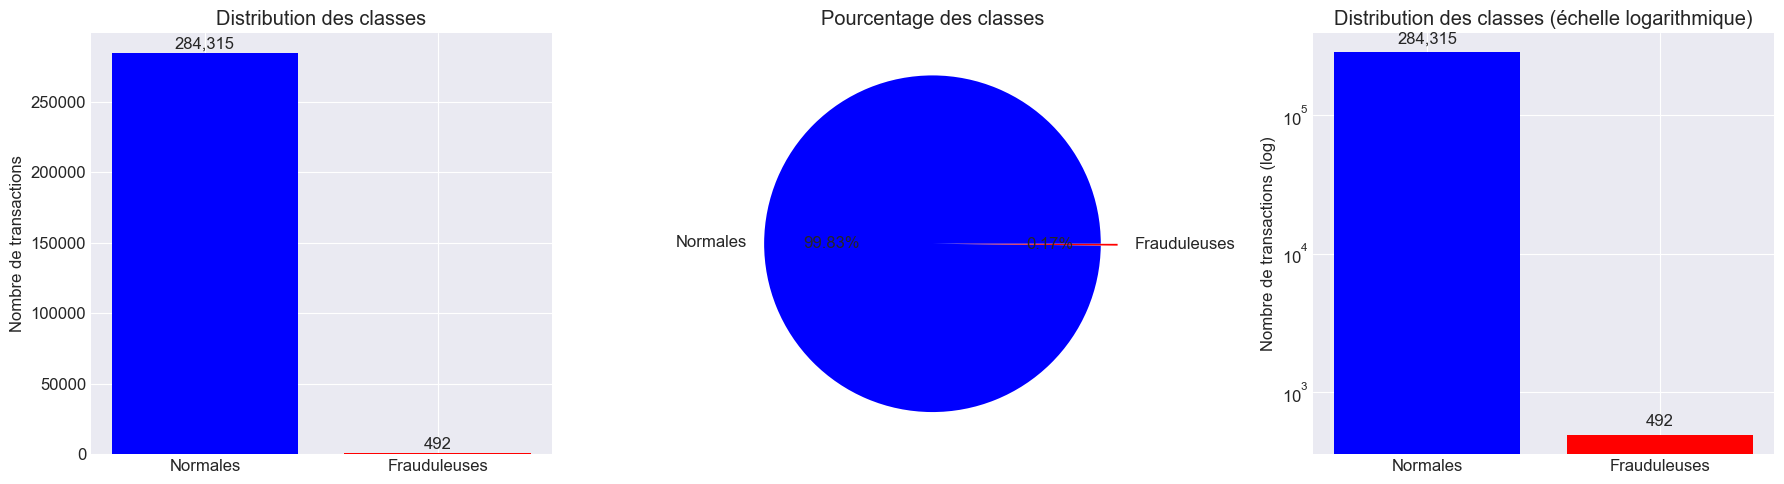

In [9]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar plot
axes[0].bar(['Normales', 'Frauduleuses'], class_counts.values, color=['blue', 'red'])
axes[0].set_title('Distribution des classes')
axes[0].set_ylabel('Nombre de transactions')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom')

# Pie chart
axes[1].pie(class_counts.values, labels=['Normales', 'Frauduleuses'], 
            autopct='%1.2f%%', colors=['blue', 'red'], explode=(0, 0.1))
axes[1].set_title('Pourcentage des classes')

# Bar plot log scale
axes[2].bar(['Normales', 'Frauduleuses'], class_counts.values, color=['blue', 'red'])
axes[2].set_title('Distribution des classes (échelle logarithmique)')
axes[2].set_ylabel('Nombre de transactions (log)')
axes[2].set_yscale('log')
for i, v in enumerate(class_counts.values):
    axes[2].text(i, v * 1.1, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 3.2 Distribution des montants (Amount)

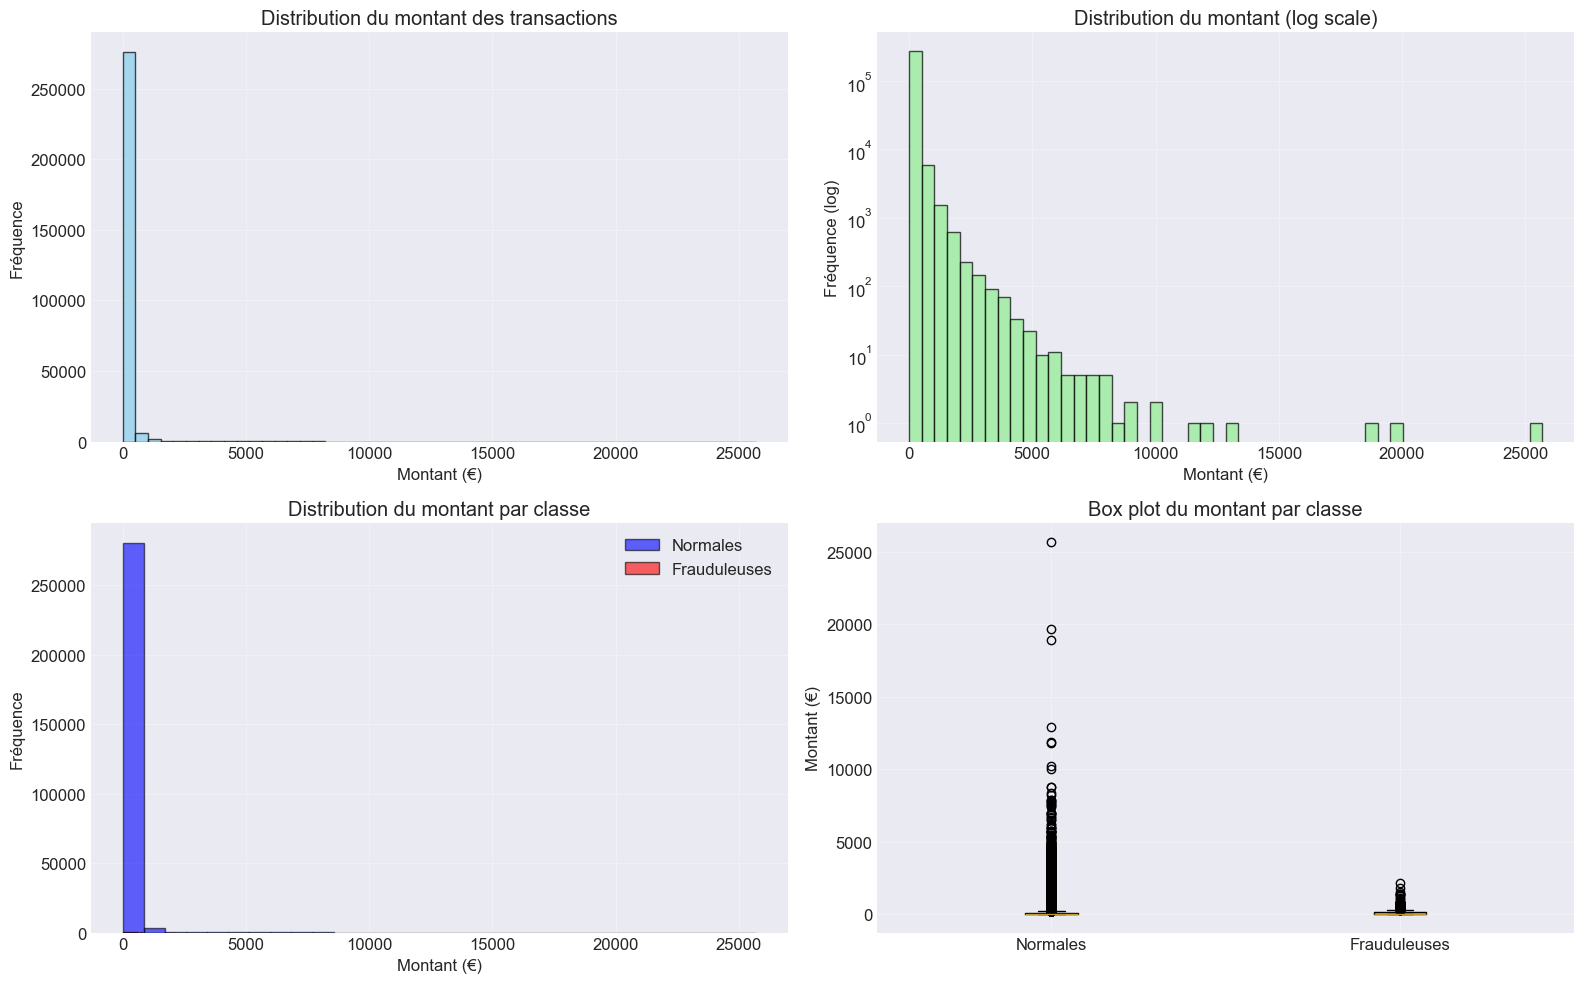

Statistiques du montant par classe:

Transactions normales:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Transactions frauduleuses:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
# Distribution du montant pour toutes les transactions
axes[0, 0].hist(df['Amount'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution du montant des transactions')
axes[0, 0].set_xlabel('Montant (€)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].grid(True, alpha=0.3)

# Distribution du montant (échelle logarithmique)
axes[0, 1].hist(df['Amount'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7, log=True)
axes[0, 1].set_title('Distribution du montant (log scale)')
axes[0, 1].set_xlabel('Montant (€)')
axes[0, 1].set_ylabel('Fréquence (log)')
axes[0, 1].grid(True, alpha=0.3)
# Distribution par classe
for cls, color, label in [(0, 'blue', 'Normales'), (1, 'red', 'Frauduleuses')]:
    axes[1, 0].hist(df[df['Class'] == cls]['Amount'], 
                   bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
axes[1, 0].set_title('Distribution du montant par classe')
axes[1, 0].set_xlabel('Montant (€)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
# Box plot par classe
data_to_plot = [df[df['Class'] == 0]['Amount'], df[df['Class'] == 1]['Amount']]
axes[1, 1].boxplot(data_to_plot, labels=['Normales', 'Frauduleuses'])
axes[1, 1].set_title('Box plot du montant par classe')
axes[1, 1].set_ylabel('Montant (€)')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Statistiques du montant par classe
print("Statistiques du montant par classe:")
print("\nTransactions normales:")
print(df[df['Class'] == 0]['Amount'].describe())
print("\nTransactions frauduleuses:")
print(df[df['Class'] == 1]['Amount'].describe())

# Histogramme standard:
# bins=50: 50 intervalles
# Montre la distribution des montants
# La plupardes transactions sont de faible montant

# Box plot:
# Montre médiane, quartiles, outliers
# vert=False: Horizontal au lieu de vertical
# Permet de voir les valeurs extrêmes

# Histogramme en échelle logarithmique:
# log=True: Échelle log sur l'axe Y
# Mieux visualise la queue de distribution
# Montre les transactions de très haut montant

#### 3.3 Distribution du temps (Time)

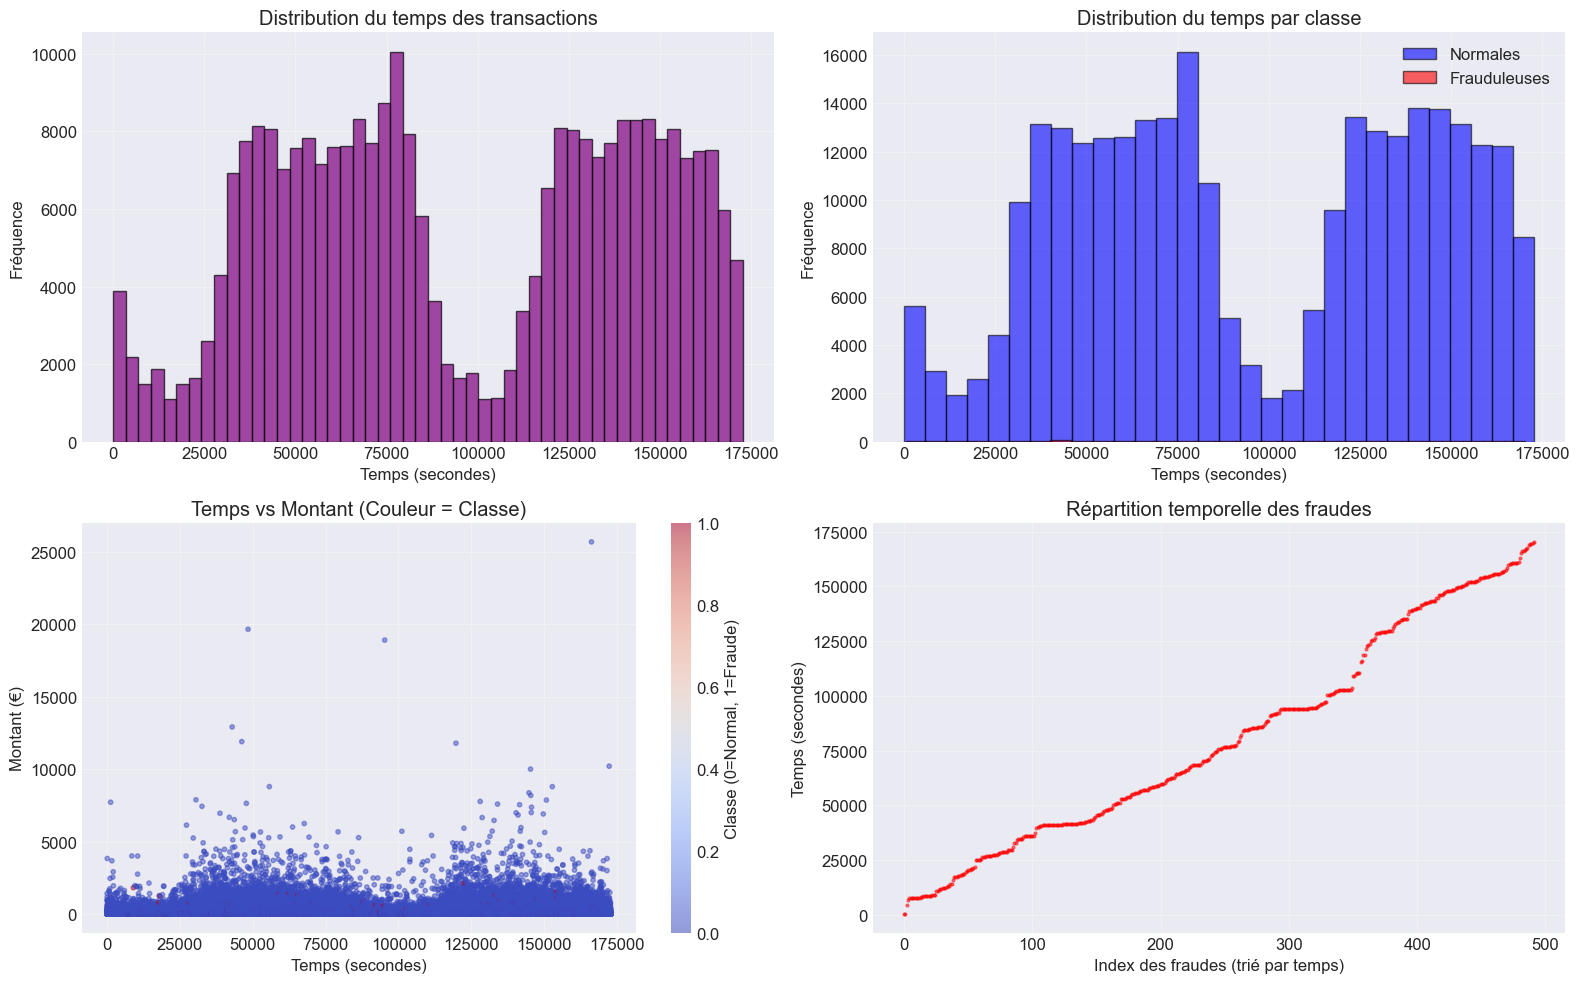


 les Transactions frauduleuses par heure:
count    46.000000
mean     10.695652
std       8.262014
min       1.000000
25%       5.250000
50%       9.000000
75%      14.000000
max      43.000000
dtype: float64


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribution du temps
axes[0, 0].hist(df['Time'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribution du temps des transactions')
axes[0, 0].set_xlabel('Temps (secondes)')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].grid(True, alpha=0.3)
# Distribution du temps par classe
for cls, color, label in [(0, 'blue', 'Normales'), (1, 'red', 'Frauduleuses')]:
    axes[0, 1].hist(df[df['Class'] == cls]['Time'], 
                   bins=30, alpha=0.6, color=color, label=label, edgecolor='black')
axes[0, 1].set_title('Distribution du temps par classe')
axes[0, 1].set_xlabel('Temps (secondes)')
axes[0, 1].set_ylabel('Fréquence')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
# Scatter plot: Temps vs Montant
scatter = axes[1, 0].scatter(df['Time'], df['Amount'], 
                            c=df['Class'], cmap='coolwarm', alpha=0.5, s=10)
axes[1, 0].set_title('Temps vs Montant (Couleur = Classe)')
axes[1, 0].set_xlabel('Temps (secondes)')
axes[1, 0].set_ylabel('Montant (€)')
plt.colorbar(scatter, ax=axes[1, 0], label='Classe (0=Normal, 1=Fraude)')
axes[1, 0].grid(True, alpha=0.3)
# Transactions frauduleuses dans le temps
fraud_times = df[df['Class'] == 1]['Time']
axes[1, 1].plot(fraud_times.sort_values().values, 'ro', alpha=0.5, markersize=2)
axes[1, 1].set_title('Répartition temporelle des fraudes')
axes[1, 1].set_xlabel('Index des fraudes (trié par temps)')
axes[1, 1].set_ylabel('Temps (secondes)')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Convertir le temps en heures pour analyse
df['Hour'] = df['Time'] // 3600
fraud_by_hour = df[df['Class'] == 1].groupby('Hour').size()
normal_by_hour = df[df['Class'] == 0].groupby('Hour').size()
print("\n les Transactions frauduleuses par heure:")
print(fraud_by_hour.describe())

# Sélectionner les features V1-V28

In [12]:
v_features = [f'V{i}' for i in range(1, 29)]

# Statistiques des features V
print(" Statistiques des features V1-V28:")
v_stats = df[v_features].describe().T
v_stats['abs_mean'] = np.abs(v_stats['mean'])
v_stats['std_to_mean'] = np.abs(v_stats['std'] / v_stats['mean']).replace([np.inf, -np.inf], np.nan)
print(v_stats[['mean', 'std', 'min', 'max', 'abs_mean']].head(10))

 Statistiques des features V1-V28:
             mean       std         min         max      abs_mean
V1   1.168375e-15  1.958696  -56.407510    2.454930  1.168375e-15
V2   3.416908e-16  1.651309  -72.715728   22.057729  3.416908e-16
V3  -1.379537e-15  1.516255  -48.325589    9.382558  1.379537e-15
V4   2.074095e-15  1.415869   -5.683171   16.875344  2.074095e-15
V5   9.604066e-16  1.380247 -113.743307   34.801666  9.604066e-16
V6   1.487313e-15  1.332271  -26.160506   73.301626  1.487313e-15
V7  -5.556467e-16  1.237094  -43.557242  120.589494  5.556467e-16
V8   1.213481e-16  1.194353  -73.216718   20.007208  1.213481e-16
V9  -2.406331e-15  1.098632  -13.434066   15.594995  2.406331e-15
V10  2.239053e-15  1.088850  -24.588262   23.745136  2.239053e-15


#### 3.5 Matrice de corrélation

 les 10 features les plus corrélées avec la classe:
Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
Name: Class, dtype: float64

 les 10 features les moins corrélées avec la classe:
V9    -0.097733
V1    -0.101347
V18   -0.111485
V7    -0.187257
V3    -0.192961
V16   -0.196539
V10   -0.216883
V12   -0.260593
V14   -0.302544
V17   -0.326481
Name: Class, dtype: float64


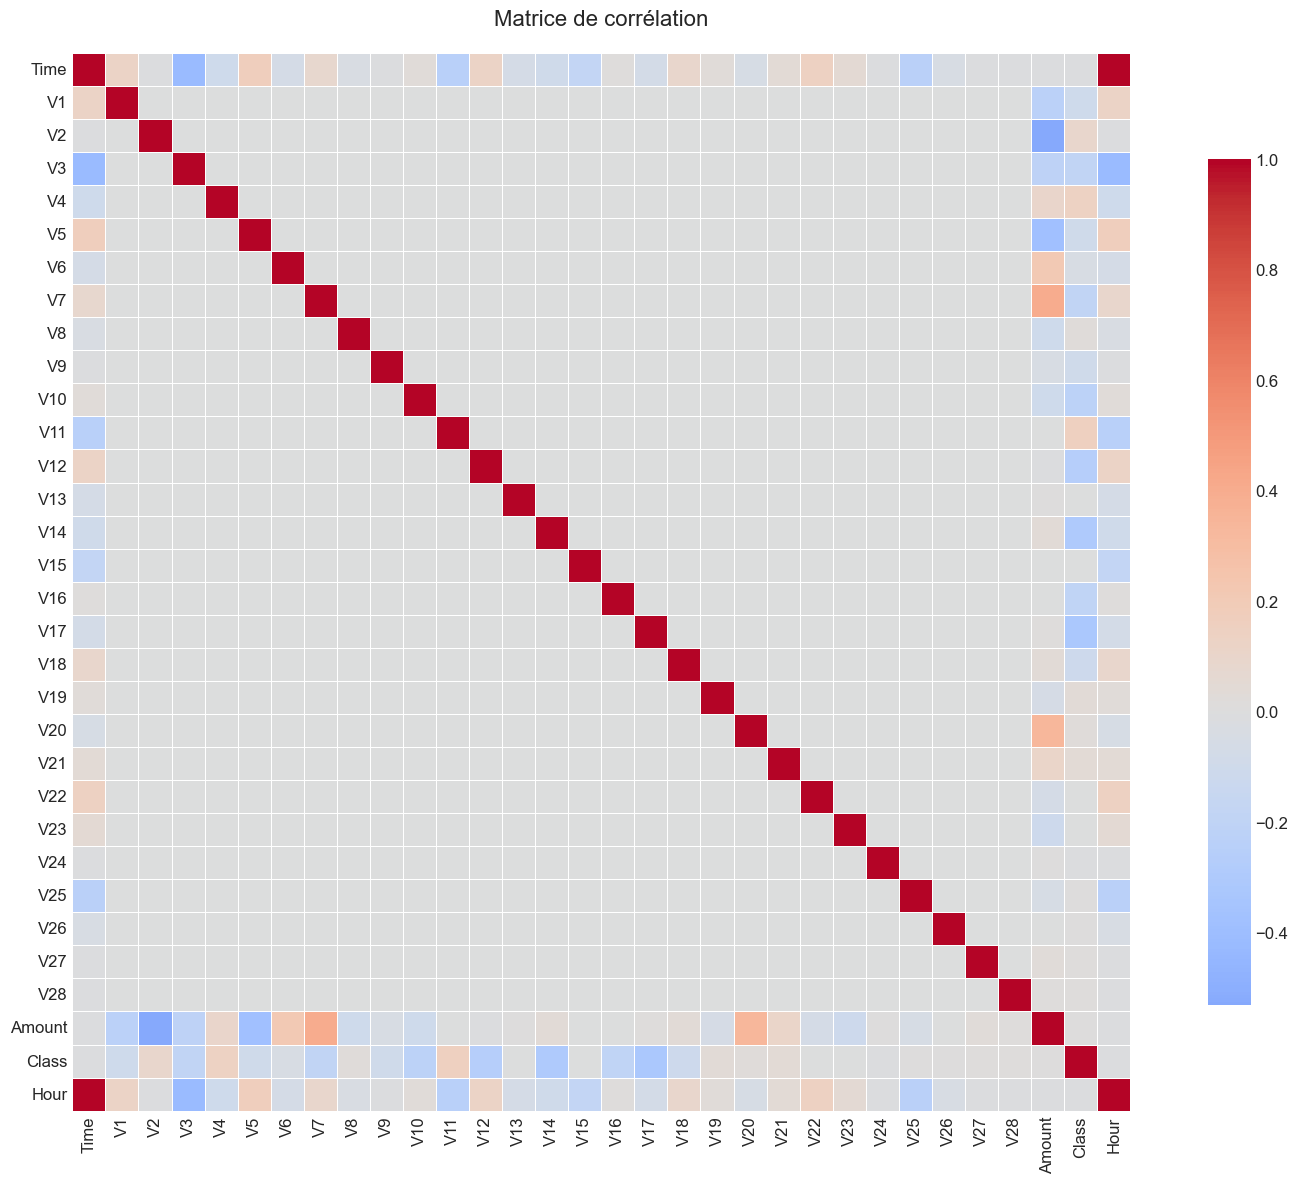

In [13]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Focus sur la corrélation avec la variable cible
correlation_with_class = correlation_matrix['Class'].sort_values(ascending=False)

print(" les 10 features les plus corrélées avec la classe:")
print(correlation_with_class.head(10))
print("\n les 10 features les moins corrélées avec la classe:")
print(correlation_with_class.tail(10))

# Visualisation de la matrice de corrélation
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matrice de corrélation', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


#### 3.6 Visualisation des corrélations avec la classe

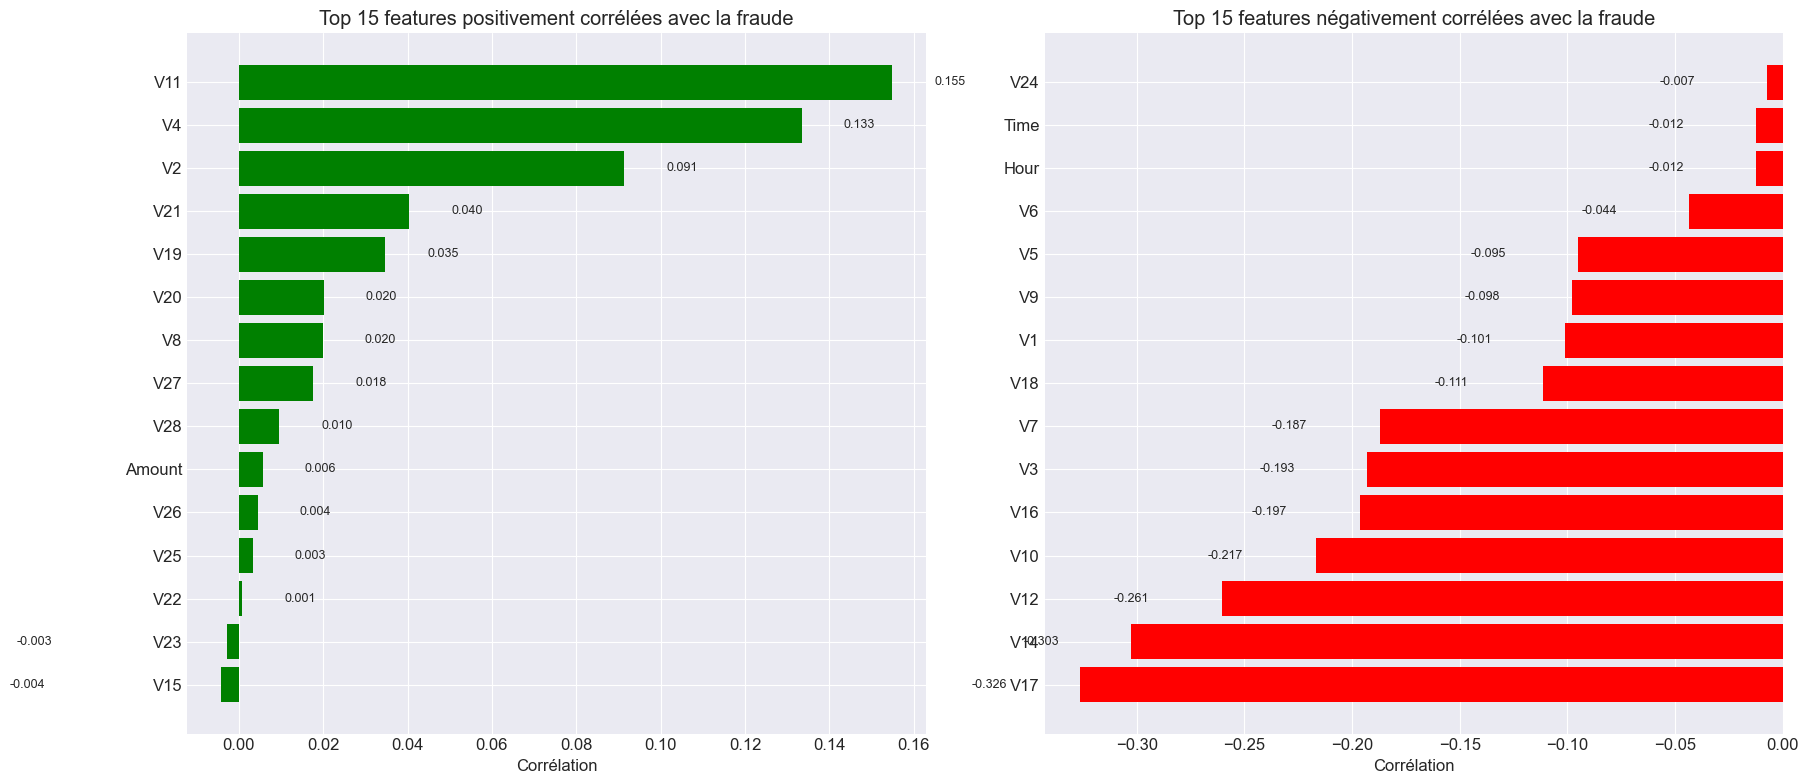

In [14]:
# Créer un dataframe pour la corrélation avec la classe
corr_df = pd.DataFrame({
    'Feature': correlation_with_class.index,
    'Correlation': correlation_with_class.values
})

# Filtrer pour exclure la corrélation avec elle-même (Class)
corr_df = corr_df[corr_df['Feature'] != 'Class']

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar plot des corrélations
top_n = 15
top_pos = corr_df.head(top_n)
top_neg = corr_df.tail(top_n)

# Features positivement corrélées
axes[0].barh(range(len(top_pos)), top_pos['Correlation'].values, color='green')
axes[0].set_yticks(range(len(top_pos)))
axes[0].set_yticklabels(top_pos['Feature'].values)
axes[0].set_xlabel('Corrélation')
axes[0].set_title(f'Top {top_n} features positivement corrélées avec la fraude')
axes[0].invert_yaxis()
for i, v in enumerate(top_pos['Correlation'].values):
    axes[0].text(v + 0.01 if v >= 0 else v - 0.05, i, f'{v:.3f}', 
                va='center', fontsize=9)
# Features négativement corrélées
axes[1].barh(range(len(top_neg)), top_neg['Correlation'].values, color='red')
axes[1].set_yticks(range(len(top_neg)))
axes[1].set_yticklabels(top_neg['Feature'].values)
axes[1].set_xlabel('Corrélation')
axes[1].set_title(f'Top {top_n} features négativement corrélées avec la fraude')
axes[1].invert_yaxis()
for i, v in enumerate(top_neg['Correlation'].values):
    axes[1].text(v + 0.01 if v >= 0 else v - 0.05, i, f'{v:.3f}', 
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

#### 3.7 Distribution des features les plus importantes

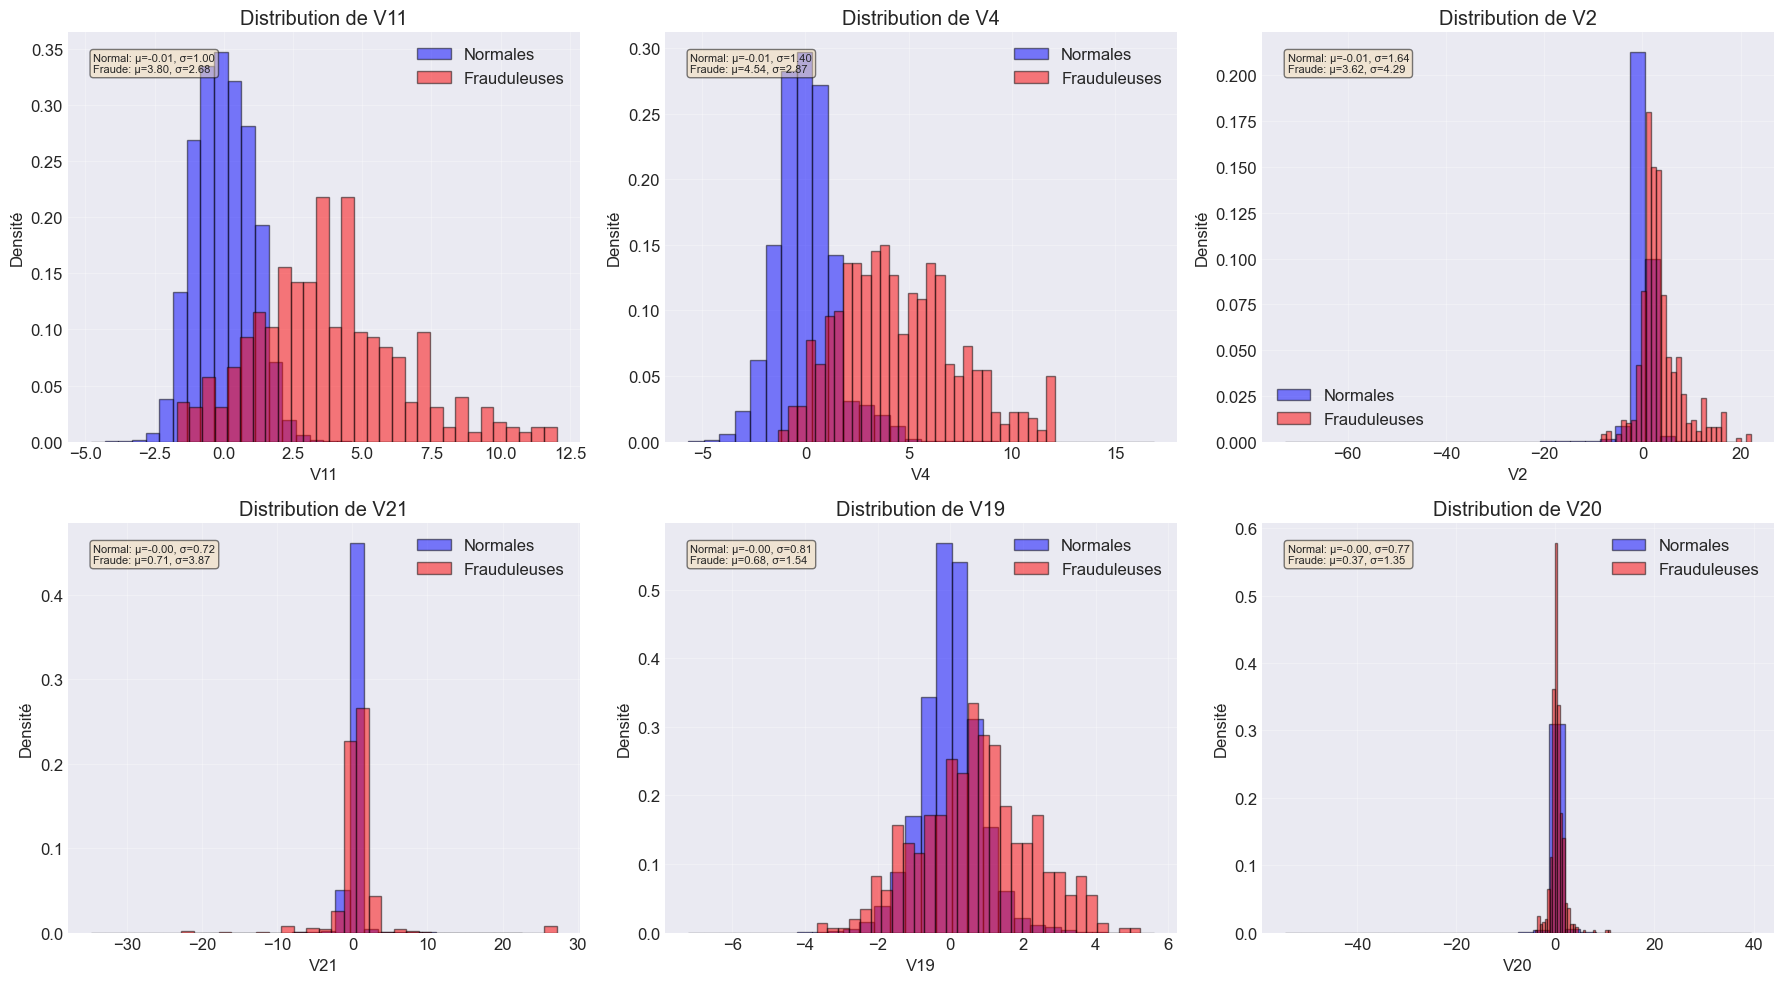

In [15]:
# Sélectionner les 6 features les plus corrélées
top_features = list(correlation_with_class.index[1:7])  # Exclure 'Class'

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    # Créer des bins pour la visualisation
    data_normal = df[df['Class'] == 0][feature]
    data_fraud = df[df['Class'] == 1][feature]
    
    # Histogramme superposé
    axes[idx].hist(data_normal, bins=30, alpha=0.5, label='Normales', 
                  color='blue', density=True, edgecolor='black')
    axes[idx].hist(data_fraud, bins=30, alpha=0.5, label='Frauduleuses', 
                  color='red', density=True, edgecolor='black')
    
    axes[idx].set_title(f'Distribution de {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Densité')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    
    # Ajouter les statistiques
    stats_text = f'Normal: μ={data_normal.mean():.2f}, σ={data_normal.std():.2f}\n'
    stats_text += f'Fraude: μ={data_fraud.mean():.2f}, σ={data_fraud.std():.2f}'
    axes[idx].text(0.05, 0.95, stats_text, transform=axes[idx].transAxes,
                  fontsize=8, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

### 4. Préparation des données

#### 4.1 Séparation des features et de la target

In [16]:
# Séparer les features et la target
X = df.drop('Class', axis=1)
y = df['Class']

print(f"Dimensions de X: {X.shape}")
print(f"Dimensions de y: {y.shape}")

Dimensions de X: (284807, 31)
Dimensions de y: (284807,)


#### 4.2 Normalisation des features

In [17]:
# Normalisation des features 'Time' et 'Amount' 
# (les autres features V1-V28 sont déjà normalisées par PCA)

# Utiliser RobustScaler qui est moins sensible aux outliers
scaler = RobustScaler()

# Créer une copie pour la normalisation
X_scaled = X.copy()

# Normaliser Time et Amount
X_scaled[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

print("\n Statistiques après normalisation:")
print(X_scaled[['Time', 'Amount']].describe())


 Statistiques après normalisation:
                Time         Amount
count  284807.000000  284807.000000
mean        0.118914       0.927124
std         0.557903       3.495006
min        -0.994983      -0.307413
25%        -0.358210      -0.229162
50%         0.000000       0.000000
75%         0.641790       0.770838
max         1.035022     358.683155


#### 4.3 Division train/test (stratifiée)

In [18]:
# Division stratifiée pour conserver la distribution des classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

print(f" Distribution des classes dans l'ensemble d'entraînement:")
print(f"  Transactions normales: {sum(y_train == 0):,} ({sum(y_train == 0)/len(y_train)*100:.2f}%)")
print(f"  Transactions frauduleuses: {sum(y_train == 1):,} ({sum(y_train == 1)/len(y_train)*100:.2f}%)")

print(f"\n Distribution des classes dans l'ensemble de test:")
print(f"  Transactions normales: {sum(y_test == 0):,} ({sum(y_test == 0)/len(y_test)*100:.2f}%)")
print(f"  Transactions frauduleuses: {sum(y_test == 1):,} ({sum(y_test == 1)/len(y_test)*100:.2f}%)")

 Distribution des classes dans l'ensemble d'entraînement:
  Transactions normales: 199,020 (99.83%)
  Transactions frauduleuses: 344 (0.17%)

 Distribution des classes dans l'ensemble de test:
  Transactions normales: 85,295 (99.83%)
  Transactions frauduleuses: 148 (0.17%)


#### 4.4 Gestion du déséquilibre des classes


 Application de la méthode: undersampling
 Après rééchantillonnage:
  Transactions normales: 344
  Transactions frauduleuses: 344
  Ratio: 1:1.0

 Application de la méthode: oversampling_smote
 Après rééchantillonnage:
  Transactions normales: 199,020
  Transactions frauduleuses: 199,020
  Ratio: 1:1.0


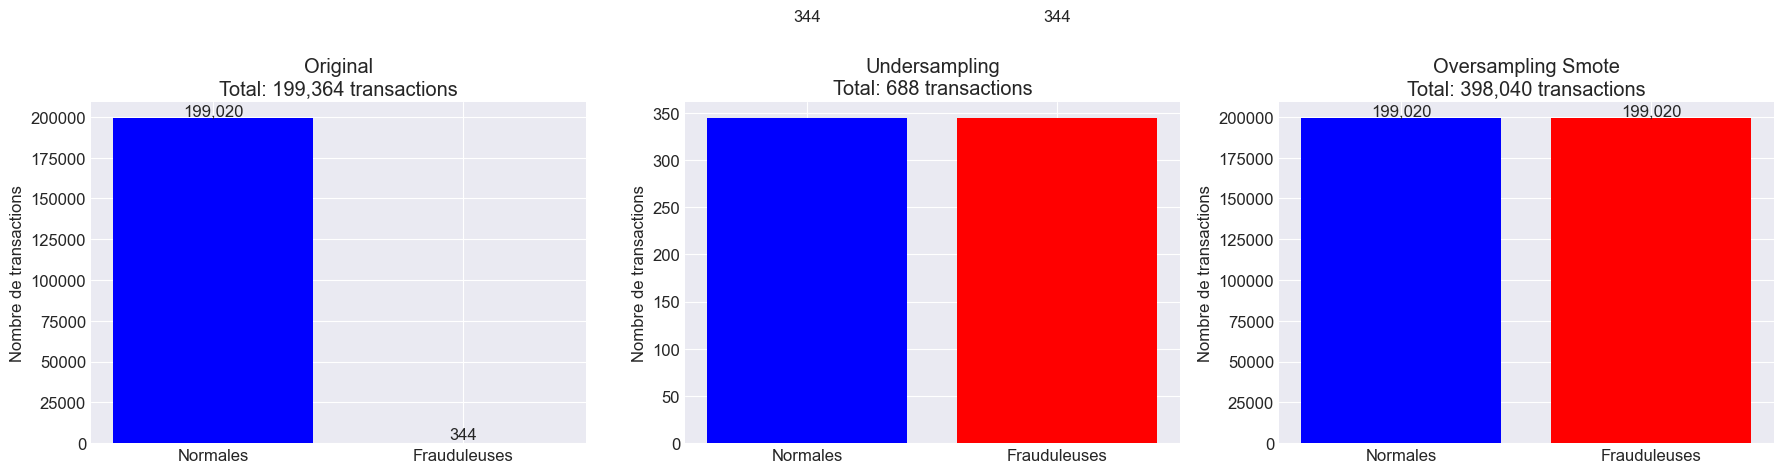

In [19]:
def apply_sampling(X_train, y_train, method='undersampling', random_state=42):
    """ Applique différentes techniques de rééchantillonnage """
    print(f"\n Application de la méthode: {method}")
    
    if method == 'undersampling':
        # Sous-échantillonnage de la classe majoritaire
        rus = RandomUnderSampler(random_state=random_state)
        X_res, y_res = rus.fit_resample(X_train, y_train)
        
    elif method == 'oversampling_smote':
        # Sur-échantillonnage avec SMOTE
        smote = SMOTE(random_state=random_state)
        X_res, y_res = smote.fit_resample(X_train, y_train)
        
    elif method == 'smote_tomek':
        # Combinaison SMOTE + Tomek links
        smote_tomek = SMOTETomek(random_state=random_state)
        X_res, y_res = smote_tomek.fit_resample(X_train, y_train)
        
    elif method == 'class_weight':
        # Utilisation des poids de classe (pas de rééchantillonnage)
        X_res, y_res = X_train, y_train
        print("Les poids de classe seront utilisés dans le modèle")
    else:
        # Pas de rééchantillonnage
        X_res, y_res = X_train, y_train
        print(" Pas de rééchantillonnage appliqué")
    
    # Afficher les nouvelles distributions
    print(f" Après rééchantillonnage:")
    print(f"  Transactions normales: {sum(y_res == 0):,}")
    print(f"  Transactions frauduleuses: {sum(y_res == 1):,}")
    print(f"  Ratio: 1:{sum(y_res == 0)/sum(y_res == 1):.1f}")
    
    return X_res, y_res
# Tester différentes méthodes
sampling_methods = ['none', 'undersampling', 'oversampling_smote']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, method in enumerate(sampling_methods):
    if method == 'none':
        X_res, y_res = X_train, y_train
        title = 'Original'
    else:
        X_res, y_res = apply_sampling(X_train, y_train, method=method)
        title = method.replace('_', ' ').title()
    
    # Visualisation
    axes[idx].bar(['Normales', 'Frauduleuses'], 
                 [sum(y_res == 0), sum(y_res == 1)], 
                 color=['blue', 'red'])
    axes[idx].set_title(f'{title}\nTotal: {len(y_res):,} transactions')
    axes[idx].set_ylabel('Nombre de transactions')
    for i, v in enumerate([sum(y_res == 0), sum(y_res == 1)]):
        axes[idx].text(i, v + 100, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [20]:
# Choisir une méthode (undersampling est souvent bon pour les fraudes)
chosen_method = 'undersampling'
X_train_res, y_train_res = apply_sampling(X_train, y_train, method=chosen_method)


 Application de la méthode: undersampling
 Après rééchantillonnage:
  Transactions normales: 344
  Transactions frauduleuses: 344
  Ratio: 1:1.0


### 5. Modélisation avec Random Forest

#### 5.1 Modèle Random Forest de base

In [21]:
# Initialiser le modèle Random Forest
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,  # Utiliser tous les cœurs
    verbose=0
)

In [22]:
# Entraîner le modèle
print(" Entraînement du modèle Random Forest de base...")
start_time = time.time()
rf_base.fit(X_train_res, y_train_res)
#La méthode .fit() prend les données d'entraînement (X) et les réponses correctes (y) et construit l'arbre de décision (la forêt aléatoire).
#X_train_res, c'est-à-dire les données ré-échantillonnées (le petit dataset de 688 lignes créé par l'undersampling que vous avez choisi précédemment).
training_time = time.time() - start_time

print(f" Modèle entraîné en {training_time:.2f} secondes")

 Entraînement du modèle Random Forest de base...
 Modèle entraîné en 1.89 secondes


#### 5.2 Importance des features

In [23]:
# Extraire l'importance des features
feature_importance = pd.DataFrame({
    'feature': X_train_res.columns,
    'importance': rf_base.feature_importances_  
}).sort_values('importance', ascending=False)
#: Une fois entraîné, le Random Forest assigne un score à chaque variable (V1, V2, Time, Amount, etc.).
#Ce score représente la "pureté" : À quel point cette variable a-t-elle aidé à séparer proprement les fraudes des non-fraudes ? 
#Plus le score est haut, plus la variable est cruciale.

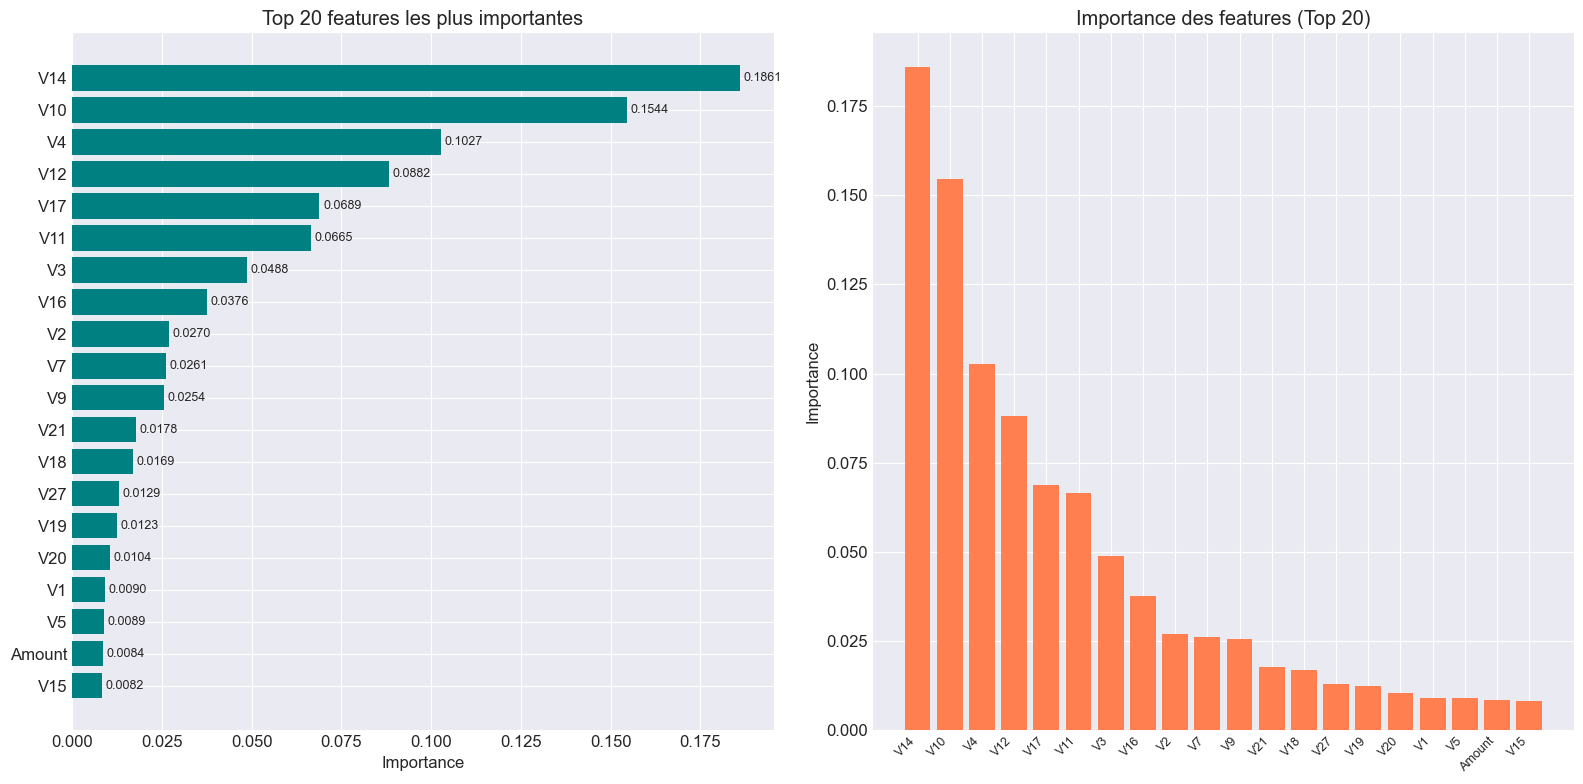

In [24]:
# Visualisation des top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar plot horizontal
axes[0].barh(range(len(top_features)), top_features['importance'], color='teal')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'])
axes[0].set_xlabel('Importance')
axes[0].set_title(f'Top {top_n} features les plus importantes')
axes[0].invert_yaxis()
# Ajouter les valeurs
for i, v in enumerate(top_features['importance']):
    axes[0].text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=9)

# Bar plot vertical
axes[1].bar(range(len(top_features)), top_features['importance'], color='coral')
axes[1].set_xticks(range(len(top_features)))
axes[1].set_xticklabels(top_features['feature'], rotation=45, ha='right')
axes[1].set_ylabel('Importance')
axes[1].set_title(f'Importance des features (Top {top_n})')
axes[1].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

In [25]:
"""
Comparaison avec votre analyse précédente : C'est très intéressant de comparer cela avec votre Matrice de Corrélation
Dans la matrice, V14 était la variable la plus négativement corrélée (-0.30).
Ici, le Random Forest confirme que V14 est la variable la plus importante tout court.
Cela valide que votre analyse exploratoire (EDA) était correcte : vous aviez repéré les bonnes variables avant même de lancer l'IA.
Les perdants : Regardez tout en bas du graphique : Amount (le montant) est très bas dans la liste.
Cela confirme ce qu'on voyait sur les histogrammes : le montant seul ne suffit pas à dire si c'est une fraude, 
car il y a des fraudes de tous montants. Le comportement mathématique (V14, V10) est bien plus révélateur que la somme d'argent dépensée.
"""

"\nComparaison avec votre analyse précédente : C'est très intéressant de comparer cela avec votre Matrice de Corrélation\nDans la matrice, V14 était la variable la plus négativement corrélée (-0.30).\nIci, le Random Forest confirme que V14 est la variable la plus importante tout court.\nCela valide que votre analyse exploratoire (EDA) était correcte : vous aviez repéré les bonnes variables avant même de lancer l'IA.\nLes perdants : Regardez tout en bas du graphique : Amount (le montant) est très bas dans la liste.\nCela confirme ce qu'on voyait sur les histogrammes : le montant seul ne suffit pas à dire si c'est une fraude, \ncar il y a des fraudes de tous montants. Le comportement mathématique (V14, V10) est bien plus révélateur que la somme d'argent dépensée.\n"

In [26]:
# Afficher le tableau des importances
print( "Top 10 des features les plus importantes:")
print(top_features.head(10))

Top 10 des features les plus importantes:
   feature  importance
14     V14    0.186096
10     V10    0.154443
4       V4    0.102695
12     V12    0.088158
17     V17    0.068870
11     V11    0.066503
3       V3    0.048765
16     V16    0.037603
2       V2    0.026959
7       V7    0.026076


#### 5.3 Évaluation du modèle de base

In [27]:
def evaluate_model(model, X_test, y_test, model_name="Modèle"):
    # Prédictions
    y_pred = model.predict(X_test)  #Le modèle donne sa réponse finale (0 ou 1).
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Le modèle donne sa "certitude"  que c'est une fraude"
    
    # Calcul des métriques
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    # Matrice de confusion :Elle compte les bonnes et mauvaises réponses en 4 catégories (TN, FP, FN, TP).
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Taux supplémentaires
    metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    metrics['false_positive_rate'] = fp / (fp + tn) if (fp + tn) > 0 else 0
    metrics['false_negative_rate'] = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # Affichage
    print(f"ÉVALUATION: {model_name}")
    print(f"\n  Métriques principales:")
    print(f"  Accuracy:    {metrics['accuracy']:.4f}")
    print(f"  Precision:   {metrics['precision']:.4f}")
    print(f"  Recall:      {metrics['recall']:.4f}")
    print(f"  F1-Score:    {metrics['f1']:.4f}")
    print(f"  ROC-AUC:     {metrics['roc_auc']:.4f}")
    
    print(f"\n Taux spécifiques:")
    print(f"  Specificity: {metrics['specificity']:.4f}")
    print(f"  FPR:         {metrics['false_positive_rate']:.4f}")
    print(f"  FNR:         {metrics['false_negative_rate']:.4f}")
    
    print(f"\n Matrice de confusion:")
    print(f"  Vrais Négatifs (TN): {tn}")
    print(f"  Faux Positifs (FP):  {fp}")
    print(f"  Faux Négatifs (FN):  {fn}")
    print(f"  Vrais Positifs (TP): {tp}")
    
    print(f"\n Rapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['Normales', 'Frauduleuses']))
    
    return metrics, cm, y_pred_proba
    

In [28]:
# Évaluation du modèle de base
base_metrics, base_cm, base_y_pred_proba = evaluate_model(rf_base, X_test, y_test, "Random Forest Base")

ÉVALUATION: Random Forest Base

  Métriques principales:
  Accuracy:    0.9824
  Precision:   0.0804
  Recall:      0.8784
  F1-Score:    0.1474
  ROC-AUC:     0.9717

 Taux spécifiques:
  Specificity: 0.9826
  FPR:         0.0174
  FNR:         0.1216

 Matrice de confusion:
  Vrais Négatifs (TN): 83809
  Faux Positifs (FP):  1486
  Faux Négatifs (FN):  18
  Vrais Positifs (TP): 130

 Rapport de classification:
              precision    recall  f1-score   support

    Normales       1.00      0.98      0.99     85295
Frauduleuses       0.08      0.88      0.15       148

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.57     85443
weighted avg       1.00      0.98      0.99     85443



In [29]:
# Accuracy (0.9824) : 98.2%-> Attention : Ce chiffre est trompeur ! Il est élevé uniquement parce qu'il est facile de deviner les transactions normales. Ne vous fiez pas à ce chiffre.
# Recall (Rappel) : 0.8784 (87.8%)
# Définition : Sur 100 fraudes réelle on a attrapé presque 88% des fraudes. Pour une banque, c'est rassurant, on laisse passer peu de voleurs.
# Precision : 0.0804 (8%)
# Définition : Quand le modèle crie "FRAUDE !", a-t-il raison ?
# Verdict : Mauvais. Seulement 8% du temps, c'est une vraie fraude. Cela signifie que pour attraper 1 vrai fraudeur, vous dérangez environ 11 ou 12 clients honnêtes.

#### 5.4 Visualisation des résultats du modèle de base

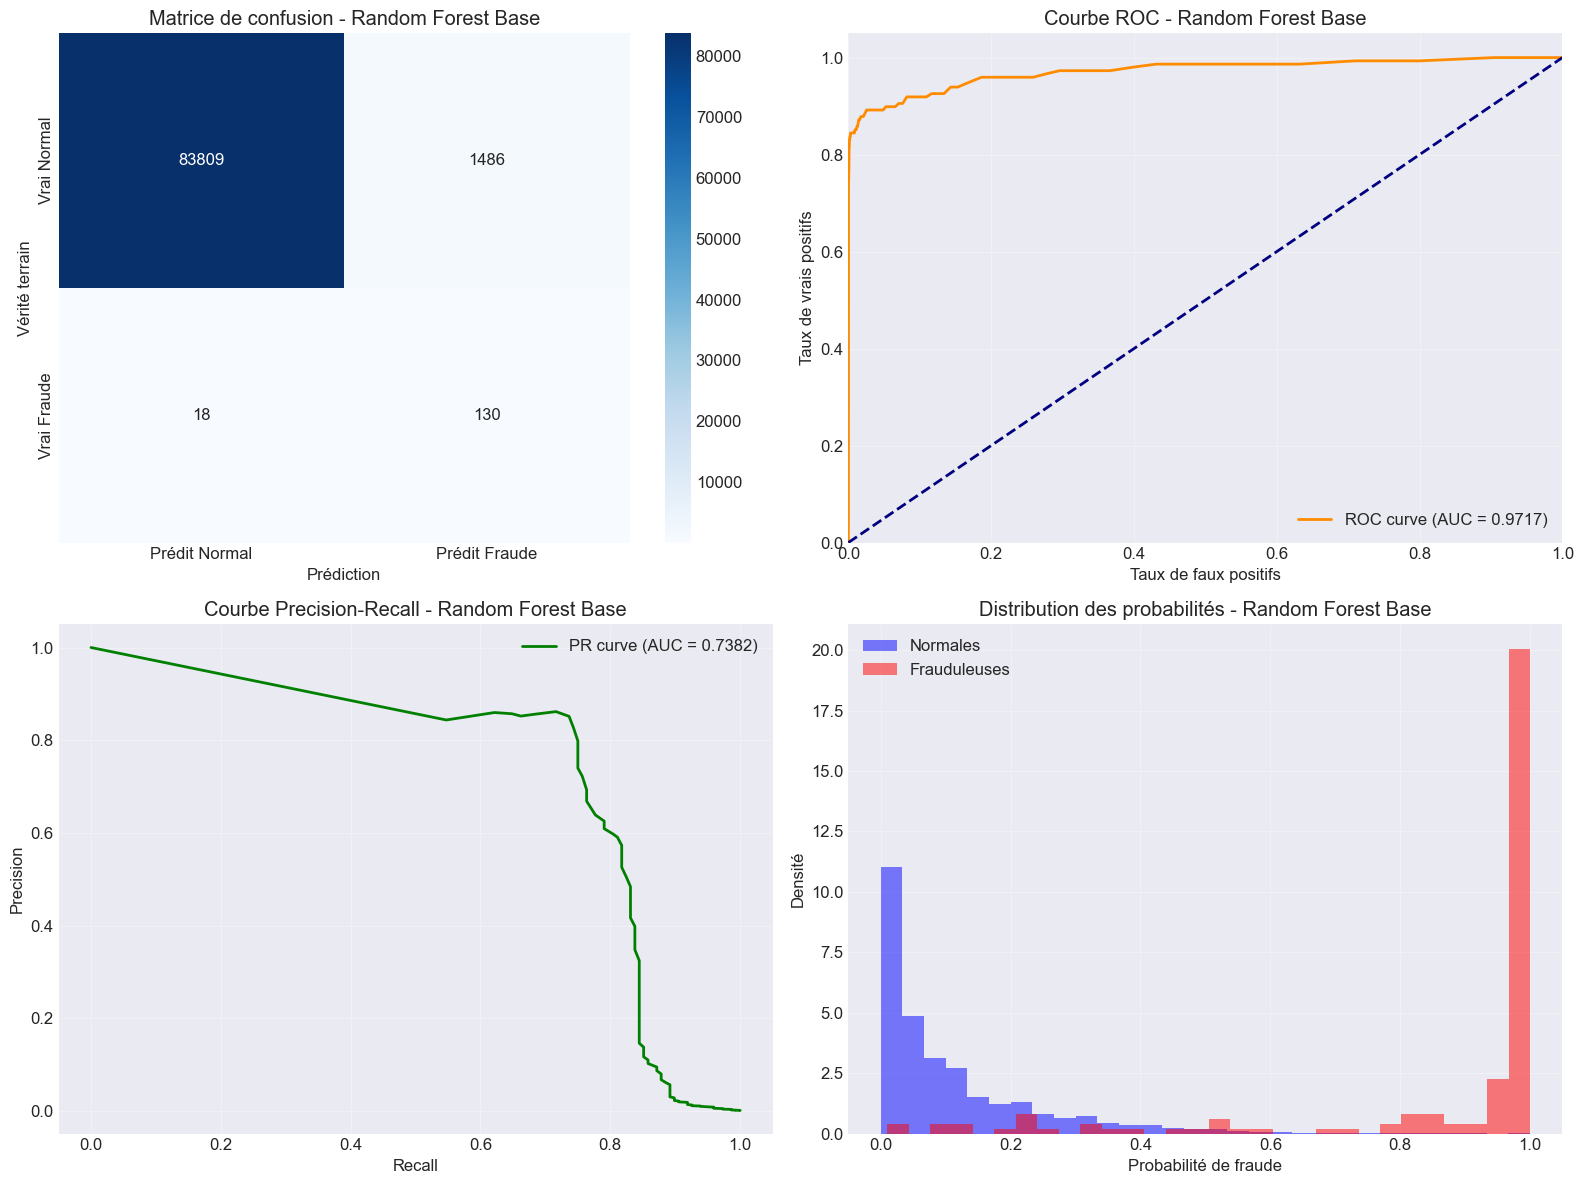

In [30]:
def plot_model_results(y_test, y_pred_proba, cm, model_name="Modèle"):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Matrice de confusion
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=['Prédit Normal', 'Prédit Fraude'],
                yticklabels=['Vrai Normal', 'Vrai Fraude'])
    axes[0, 0].set_title(f'Matrice de confusion - {model_name}')
    axes[0, 0].set_ylabel('Vérité terrain')
    axes[0, 0].set_xlabel('Prédiction')
    
    # 2. Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('Taux de faux positifs')
    axes[0, 1].set_ylabel('Taux de vrais positifs')
    axes[0, 1].set_title(f'Courbe ROC - {model_name}')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)
    # 3. Courbe Precision-Recall
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    axes[1, 0].plot(recall, precision, color='green', lw=2,
                   label=f'PR curve (AUC = {pr_auc:.4f})')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title(f'Courbe Precision-Recall - {model_name}')
    axes[1, 0].legend(loc="upper right")
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Distribution des probabilités de prédiction
    axes[1, 1].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.5, 
                   label='Normales', color='blue', density=True)
    axes[1, 1].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.5, 
                   label='Frauduleuses', color='red', density=True)
    axes[1, 1].set_xlabel('Probabilité de fraude')
    axes[1, 1].set_ylabel('Densité')
    axes[1, 1].set_title(f'Distribution des probabilités - {model_name}')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return roc_auc, pr_auc
# Visualiser les résultats du modèle de base
roc_auc_base, pr_auc_base = plot_model_results(y_test, base_y_pred_proba, base_cm, "Random Forest Base")

#### 5.5 Optimisation des hyperparamètres avec Grid Search

In [31]:
# Définir la grille d'hyperparamètres pour l'optimisation
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

In [32]:
# Initialiser le modèle pour GridSearch
rf_for_grid = RandomForestClassifier(random_state=42, n_jobs=-1)

# Stratified K-Fold pour la validation croisée
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearchCV
print("Début de l'optimisation des hyperparamètres...")
print(f" Nombre de combinaisons: {np.prod([len(v) for v in param_grid.values()])}")

Début de l'optimisation des hyperparamètres...
 Nombre de combinaisons: 432


In [ ]:
start_time = time.time()

grid_search = GridSearchCV(
    estimator=rf_for_grid,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Exécuter la recherche (prend du temps)
grid_search.fit(X_train_res, y_train_res)

grid_time = time.time() - start_time
print(f" GridSearch terminé en {grid_time/60:.1f} minutes")

# Afficher les meilleurs paramètres
print(f"\n Meilleurs paramètres trouvés:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n Meilleur score ROC-AUC (validation): {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


#### 5.6 Modèle optimisé

In [ ]:
# Créer le modèle avec les meilleurs paramètres
rf_optimized = grid_search.best_estimator_

print(" Modèle optimisé créé avec les paramètres:")
print(grid_search.best_params_)

In [ ]:
# Évaluation du modèle optimisé
opt_metrics, opt_cm, opt_y_pred_proba = evaluate_model(
    rf_optimized, X_test, y_test, "Random Forest Optimisé"
)

# Visualiser les résultats du modèle optimisé
roc_auc_opt, pr_auc_opt = plot_model_results(
    y_test, opt_y_pred_proba, opt_cm, "Random Forest Optimisé"
)

#### 5.7 Comparaison des modèles

In [ ]:
# Comparaison des métriques
comparison_df = pd.DataFrame({
    'Modèle Base': base_metrics,
    'Modèle Optimisé': opt_metrics
}).T

In [ ]:
# Sélectionner les métriques à comparer
metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 
                     'specificity', 'false_positive_rate', 'false_negative_rate']

comparison_df = comparison_df[metrics_to_compare]

print(" COMPARAISON DES MODÈLES")
print(comparison_df)

In [ ]:
# Visualisation de la comparaison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Bar plot des métriques principales
metrics_main = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
x = np.arange(len(metrics_main))
width = 0.35

axes[0, 0].bar(x - width/2, comparison_df.loc['Modèle Base', metrics_main], 
               width, label='Base', color='skyblue')
axes[0, 0].bar(x + width/2, comparison_df.loc['Modèle Optimisé', metrics_main], 
               width, label='Optimisé', color='coral')

axes[0, 0].set_xlabel('Métriques')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparaison des métriques principales')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics_main)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
# Taux spécifiques
metrics_specific = ['specificity', 'false_positive_rate', 'false_negative_rate']
x = np.arange(len(metrics_specific))

axes[0, 1].bar(x - width/2, comparison_df.loc['Modèle Base', metrics_specific], 
               width, label='Base', color='lightgreen')
axes[0, 1].bar(x + width/2, comparison_df.loc['Modèle Optimisé', metrics_specific], 
               width, label='Optimisé', color='gold')

axes[0, 1].set_xlabel('Taux')
axes[0, 1].set_ylabel('Valeur')
axes[0, 1].set_title('Comparaison des taux spécifiques')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_specific)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Heatmap de comparaison
sns.heatmap(comparison_df, annot=True, fmt='.4f', cmap='YlOrRd', 
            ax=axes[1, 0], cbar_kws={'label': 'Score'})
axes[1, 0].set_title('Heatmap de comparaison des métriques')
axes[1, 0].tick_params(axis='x', rotation=45)
# Amélioration en pourcentage
improvement = ((comparison_df.loc['Modèle Optimisé'] - 
                comparison_df.loc['Modèle Base']) / 
               comparison_df.loc['Modèle Base'] * 100)

# Filtrer pour éviter les divisions par zéro
improvement = improvement.replace([np.inf, -np.inf], np.nan).dropna()

axes[1, 1].bar(improvement.index, improvement.values, color='purple')
axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].set_xlabel('Métriques')
axes[1, 1].set_ylabel('Amélioration (%)')
axes[1, 1].set_title('Amélioration du modèle optimisé (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for i, v in enumerate(improvement.values):
    axes[1, 1].text(i, v + (1 if v >= 0 else -1), f'{v:.1f}%', 
                   ha='center', va='bottom' if v >= 0 else 'top')

plt.tight_layout()
plt.show()

### 6. Validation croisée et robustesse du modèle

In [ ]:
def perform_cross_validation(model, X, y, cv_folds=5, model_name="Modèle"):

    print(f"\ Validation croisée {cv_folds}-fold pour {model_name}")    
    # Initialiser le K-Fold stratifié
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Métriques à calculer
    scoring_metrics = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    cv_results = {}
    
    for metric_name, metric_scorer in scoring_metrics.items():
        scores = cross_val_score(
            model, X, y, 
            scoring=metric_scorer, 
            cv=cv, 
            n_jobs=-1
        )
        
        cv_results[metric_name] = {
            'scores': scores,
            'mean': scores.mean(),
            'std': scores.std(),
            'min': scores.min(),
            'max': scores.max()
        }
        
        print(f"{metric_name:12s}: {scores.mean():.4f} (+/- {scores.std():.4f})")
        print(f"              Plage: [{scores.min():.4f}, {scores.max():.4f}]")
    
    return cv_results

In [ ]:
# Validation croisée pour le modèle optimisé
cv_results = perform_cross_validation(rf_optimized, X_train_res, y_train_res, 
                                     cv_folds=5, model_name="Random Forest Optimisé")

In [ ]:
# Visualisation des résultats de la validation croisée
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot des scores
metrics_names = list(cv_results.keys())
scores_data = [cv_results[metric]['scores'] for metric in metrics_names]

box = axes[0].boxplot(scores_data, patch_artist=True, labels=metrics_names)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon', 'plum']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

axes[0].set_title('Distribution des scores - Validation croisée 5-fold')
axes[0].set_ylabel('Score')
axes[0].grid(True, alpha=0.3, axis='y')

# Bar plot avec intervalles de confiance
means = [cv_results[metric]['mean'] for metric in metrics_names]
stds = [cv_results[metric]['std'] for metric in metrics_names]
x_pos = np.arange(len(metrics_names))
bars = axes[1].bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.7)
axes[1].set_xlabel('Métriques')
axes[1].set_ylabel('Score moyen')
axes[1].set_title('Scores moyens avec écarts-types')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(metrics_names)
axes[1].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + std + 0.01,
                f'{mean:.3f}\n±{std:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 7. Analyse des erreurs et seuil optimal

In [ ]:
def find_optimal_threshold(y_test, y_pred_proba):
    # Calculer Precision et Recall pour différents seuils
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
    # Calculer F1-Score pour chaque seuil
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Trouver le seuil optimal (max F1)
    optimal_idx = np.argmax(f1_scores[:-1])  # Exclure le dernier élément
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    # Calculer les métriques pour différents seuils
    threshold_values = np.arange(0.1, 0.9, 0.05)
    results = []
    
    for threshold in threshold_values:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        results.append({
            'threshold': threshold,
            'precision': precision_score(y_test, y_pred_thresh, zero_division=0),
            'recall': recall_score(y_test, y_pred_thresh),
            'f1': f1_score(y_test, y_pred_thresh),
            'accuracy': accuracy_score(y_test, y_pred_thresh)
        })
    
    results_df = pd.DataFrame(results)
    
    return optimal_threshold, optimal_f1, results_df, precision, recall, thresholds

In [ ]:
# Trouver le seuil optimal
optimal_threshold, optimal_f1, threshold_results, precision, recall, thresholds = \
    find_optimal_threshold(y_test, opt_y_pred_proba)
print(f" Seuil optimal trouvé: {optimal_threshold:.3f}")
print(f" F1-Score au seuil optimal: {optimal_f1:.4f}")

In [ ]:
# Visualisation des métriques selon le seuil
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Courbe Precision-Recall avec seuil optimal
axes[0, 0].plot(recall, precision, 'b-', label='Courbe Precision-Recall')
axes[0, 0].scatter(recall[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))], 
                   precision[np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))], 
                   color='red', s=100, label=f'Seuil optimal (F1-max)')
axes[0, 0].set_xlabel('Recall')
axes[0, 0].set_ylabel('Precision')
axes[0, 0].set_title('Courbe Precision-Recall avec seuil optimal')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Métriques en fonction du seuil
axes[0, 1].plot(threshold_results['threshold'], threshold_results['precision'], 
               'g-', label='Precision', linewidth=2)
axes[0, 1].plot(threshold_results['threshold'], threshold_results['recall'], 
               'b-', label='Recall', linewidth=2)
axes[0, 1].plot(threshold_results['threshold'], threshold_results['f1'], 
               'r-', label='F1-Score', linewidth=2)
axes[0, 1].axvline(x=optimal_threshold, color='black', linestyle='--', 
                  label=f'Seuil optimal = {optimal_threshold:.3f}')
axes[0, 1].set_xlabel('Seuil de décision')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Métriques en fonction du seuil de décision')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
# Heatmap des métriques par seuil
metrics_matrix = threshold_results[['precision', 'recall', 'f1', 'accuracy']].values.T
im = axes[1, 0].imshow(metrics_matrix, aspect='auto', cmap='YlOrRd')
axes[1, 0].set_xlabel('Seuil (index)')
axes[1, 0].set_ylabel('Métrique')
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_yticklabels(['Precision', 'Recall', 'F1-Score', 'Accuracy'])
axes[1, 0].set_title('Heatmap des métriques par seuil')
plt.colorbar(im, ax=axes[1, 0], label='Valeur')

# Comparaison F1-Score et Accuracy
axes[1, 1].plot(threshold_results['threshold'], threshold_results['f1'], 
               'r-', label='F1-Score', linewidth=2)
axes[1, 1].plot(threshold_results['threshold'], threshold_results['accuracy'], 
               'purple', label='Accuracy', linewidth=2)
axes[1, 1].axvline(x=optimal_threshold, color='black', linestyle='--')
axes[1, 1].set_xlabel('Seuil de décision')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('F1-Score vs Accuracy selon le seuil')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Marquer le point optimal
optimal_idx = threshold_results['threshold'].sub(optimal_threshold).abs().idxmin()
axes[1, 1].scatter(optimal_threshold, threshold_results.loc[optimal_idx, 'f1'], 
                  color='red', s=100, zorder=5)
axes[1, 1].text(optimal_threshold, threshold_results.loc[optimal_idx, 'f1'] + 0.02,
               f'Optimal\nF1={threshold_results.loc[optimal_idx, "f1"]:.3f}', 
               ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Tester le modèle avec le seuil optimal
print(f"\n🔧 Test avec le seuil optimal ({optimal_threshold:.3f}):")
y_pred_optimal = (opt_y_pred_proba >= optimal_threshold).astype(int)

print(f"Accuracy:   {accuracy_score(y_test, y_pred_optimal):.4f}")
print(f"Precision:  {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall:     {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1-Score:   {f1_score(y_test, y_pred_optimal):.4f}")

# Matrice de confusion avec seuil optimal
cm_optimal = confusion_matrix(y_test, y_pred_optimal)
tn, fp, fn, tp = cm_optimal.ravel()

print(f"\n Matrice de confusion (seuil optimal):")
print(f"TN: {tn}, FP: {fp}")
print(f"FN: {fn}, TP: {tp}")


### 8. Analyse des prédictions erronées

In [ ]:
def analyze_errors(X_test, y_test, y_pred, y_pred_proba, threshold=0.5):
    """
    Analyse les prédictions erronées du modèle
    """
    # Créer un DataFrame avec les résultats
    results_df = X_test.copy()
    results_df['True_Class'] = y_test.values
    results_df['Predicted_Class'] = y_pred
    results_df['Fraud_Probability'] = y_pred_proba
    
    # Identifier les types d'erreurs
    results_df['Error_Type'] = 'Correct'
    results_df.loc[(results_df['True_Class'] == 0) & (results_df['Predicted_Class'] == 1), 
                  'Error_Type'] = 'False_Positive'
    results_df.loc[(results_df['True_Class'] == 1) & (results_df['Predicted_Class'] == 0), 
                  'Error_Type'] = 'False_Negative'
    
    # Compter les erreurs
    error_counts = results_df['Error_Type'].value_counts()
    
    print("  Analyse des erreurs de prédiction:")

    print(f"Total des prédictions: {len(results_df)}")
    print(f"Prédictions correctes: {error_counts.get('Correct', 0)} ({error_counts.get('Correct', 0)/len(results_df)*100:.1f}%)")
    print(f"Faux Positifs (FP):    {error_counts.get('False_Positive', 0)} ({error_counts.get('False_Positive', 0)/len(results_df)*100:.1f}%)")
    print(f"Faux Négatifs (FN):    {error_counts.get('False_Negative', 0)} ({error_counts.get('False_Negative', 0)/len(results_df)*100:.1f}%)")
    # Analyser les caractéristiques des erreurs
    if error_counts.get('False_Positive', 0) > 0:
        fp_data = results_df[results_df['Error_Type'] == 'False_Positive']
        print(f"\n Caractéristiques des Faux Positifs (moyenne):")
        print(f"  Montant: €{fp_data['Amount'].mean():.2f}")
        print(f"  Probabilité de fraude: {fp_data['Fraud_Probability'].mean():.3f}")
        
    if error_counts.get('False_Negative', 0) > 0:
        fn_data = results_df[results_df['Error_Type'] == 'False_Negative']
        print(f"\n  Caractéristiques des Faux Négatifs (moyenne):")
        print(f"  Montant: €{fn_data['Amount'].mean():.2f}")
        print(f"  Probabilité de fraude: {fn_data['Fraud_Probability'].mean():.3f}")
    
    return results_df

In [ ]:
# Analyser les erreurs avec le seuil par défaut (0.5)
y_pred_default = (opt_y_pred_proba >= 0.5).astype(int)
error_analysis_df = analyze_errors(X_test, y_test, y_pred_default, opt_y_pred_proba)

# Visualisation des erreurs
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distribution des probabilités par type d'erreur
error_types = error_analysis_df['Error_Type'].unique()
colors = {'Correct': 'green', 'False_Positive': 'orange', 'False_Negative': 'red'}

for error_type in error_types:
    if error_type in error_analysis_df['Error_Type'].values:
        data = error_analysis_df[error_analysis_df['Error_Type'] == error_type]['Fraud_Probability']
        axes[0, 0].hist(data, bins=30, alpha=0.5, label=error_type.replace('_', ' '), 
                       color=colors.get(error_type, 'gray'), density=True)

axes[0, 0].set_xlabel('Probabilité de fraude')
axes[0, 0].set_ylabel('Densité')
axes[0, 0].set_title('Distribution des probabilités par type de prédiction')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Montant des transactions par type d'erreur
for error_type in error_types:
    if error_type in error_analysis_df['Error_Type'].values:
        data = error_analysis_df[error_analysis_df['Error_Type'] == error_type]['Amount']
        axes[0, 1].hist(data, bins=30, alpha=0.5, label=error_type.replace('_', ' '), 
                       color=colors.get(error_type, 'gray'), density=True)

axes[0, 1].set_xlabel('Montant (normalisé)')
axes[0, 1].set_ylabel('Densité')
axes[0, 1].set_title('Distribution du montant par type de prédiction')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Scatter plot: Montant vs Probabilité
scatter = axes[1, 0].scatter(error_analysis_df['Amount'], error_analysis_df['Fraud_Probability'],
                            c=error_analysis_df['Error_Type'].map(colors), alpha=0.6, s=20)
axes[1, 0].set_xlabel('Montant (normalisé)')
axes[1, 0].set_ylabel('Probabilité de fraude')
axes[1, 0].set_title('Montant vs Probabilité de fraude (couleur par type)')
axes[1, 0].grid(True, alpha=0.3)

# Créer une légende personnalisée
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=error_type.replace('_', ' '),
                         markerfacecolor=colors.get(error_type, 'gray'), markersize=8)
                  for error_type in error_types if error_type in error_analysis_df['Error_Type'].values]
axes[1, 0].legend(handles=legend_elements)
# Heatmap des caractéristiques moyennes par type
feature_cols = ['V14', 'V4', 'V10', 'V12', 'V16', 'Amount']
mean_by_error = error_analysis_df.groupby('Error_Type')[feature_cols].mean()

# Réorganiser pour avoir une belle heatmap
if not mean_by_error.empty:
    sns.heatmap(mean_by_error.T, annot=True, fmt='.2f', cmap='coolwarm', 
                ax=axes[1, 1], cbar_kws={'label': 'Valeur moyenne'})
    axes[1, 1].set_title('Caractéristiques moyennes par type de prédiction')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

### 9. Sauvegarde du modèle et des résultats

In [ ]:
def save_model_and_results(model, X_test, y_test, metrics, file_prefix='fraud_detection'):
    import json
    from datetime import datetime
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Sauvegarde du modèle
    model_filename = f"{file_prefix}_model_{timestamp}.pkl"
    joblib.dump(model, model_filename)
    print(f"Modèle sauvegardé: {model_filename}")
    
    # 2. Sauvegarde des métriques
    metrics_filename = f"{file_prefix}_metrics_{timestamp}.json"
    with open(metrics_filename, 'w') as f:
        json.dump(metrics, f, indent=4)
    print(f" Métriques sauvegardées: {metrics_filename}")
    # 3. Sauvegarde des prédictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    predictions_df = pd.DataFrame({
        'true_class': y_test.values,
        'predicted_class': y_pred,
        'fraud_probability': y_pred_proba
    })
    
    predictions_filename = f"{file_prefix}_predictions_{timestamp}.csv"
    predictions_df.to_csv(predictions_filename, index=False)
    print(f" Prédictions sauvegardées: {predictions_filename}")
    
    # 4. Rapport de performance
    report_filename = f"{file_prefix}_report_{timestamp}.txt"
    with open(report_filename, 'w') as f:
        f.write(f"Rapport de performance - {timestamp}\n")
        f.write(f"Modèle: Random Forest Classifier\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        
        f.write("Métriques principales:\n")
        f.write(f"  Accuracy:    {metrics['accuracy']:.4f}\n")
        f.write(f"  Precision:   {metrics['precision']:.4f}\n")
        f.write(f"  Recall:      {metrics['recall']:.4f}\n")
        f.write(f"  F1-Score:    {metrics['f1']:.4f}\n")
        f.write(f"  ROC-AUC:     {metrics['roc_auc']:.4f}\n\n")
        
        f.write("Matrice de confusion:\n")
        cm = confusion_matrix(y_test, y_pred)
        f.write(f"  TN: {cm[0,0]}, FP: {cm[0,1]}\n")
        f.write(f"  FN: {cm[1,0]}, TP: {cm[1,1]}\n")
    
    print(f" Rapport sauvegardé: {report_filename}")
    
    return {
        'model_file': model_filename,
        'metrics_file': metrics_filename,
        'predictions_file': predictions_filename,
        'report_file': report_filename
    }
# Sauvegarder le modèle optimisé
saved_files = save_model_and_results(rf_optimized, X_test, y_test, opt_metrics)    

In [1]:
import joblib


try:
    joblib.dump(rf_optimized, 'modele_fraude.joblib')
    print("✅ Modèle 'rf_optimized' sauvegardé sous 'modele_fraude.joblib'")
except NameError:
    # Si rf_optimized n'existe pas, on essaie rf_base
    joblib.dump(rf_base, 'modele_fraude.joblib')
    print(" 'rf_optimized' introuvable. Modèle 'rf_base' sauvegardé à la place.")

# 2. Sauvegarder le Scaler (Essentiel pour l'application Streamlit)
try:
    joblib.dump(rob_scaler, 'scaler.joblib')
    print(" Scaler 'rob_scaler' sauvegardé sous 'scaler.joblib'")
except NameError:
    try:
        joblib.dump(scaler, 'scaler.joblib')
        print("Scaler 'scaler' sauvegardé sous 'scaler.joblib'")
    except NameError:
        print(" ERREUR : Impossible de trouver la variable du Scaler (rob_scaler ou scaler).")

print("\n Tout est prêt ! Vous pouvez maintenant lancer l'interface Streamlit.")

NameError: name 'rf_base' is not defined